## Depth Estimation Comparison with Depth Anything and MediaPipe


In [1]:
# word = bad
MEDIAPIPE_PATH = ''
DEPTHANYTHING_PATH = ''


# see file structure
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt


def explore_h5_file(file_path):

    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"  Dataset: {name} (Shape: {obj.shape}, Dtype: {obj.dtype})")

    with h5py.File(file_path, 'r') as f:
        f.visititems(print_structure)

def explore_npz_file(file_path):
    data = np.load(file_path)
    
    print(f"Keys in {file_path}:")
    for key in data.files:
        print(f"  {key}: shape={data[key].shape}, dtype={data[key].dtype}")
    data.close()

print("Exploring MediaPipe File")
explore_h5_file(MEDIAPIPE_PATH)

print("Exploring Depthanything File")
explore_npz_file(DEPTHANYTHING_PATH)



Exploring MediaPipe File
Group: Face
  Dataset: Face/face_blendshapes (Shape: (58, 1, 52), Dtype: float64)
  Dataset: Face/face_landmarks (Shape: (58, 1, 478, 3), Dtype: float64)
Group: Hand
  Dataset: Hand/hand_landmarks (Shape: (58, 1, 21, 3), Dtype: float64)
  Dataset: Hand/hand_world_landmarks (Shape: (58, 1, 21, 3), Dtype: float64)
  Dataset: Hand/handedness (Shape: (58, 1, 1), Dtype: int8)
  Dataset: Hand/handedness_accuracy (Shape: (58, 1, 1), Dtype: float64)
Group: Hand2
  Dataset: Hand2/hand_landmarks (Shape: (58, 2, 21, 3), Dtype: float64)
  Dataset: Hand2/hand_world_landmarks (Shape: (58, 2, 21, 3), Dtype: float64)
  Dataset: Hand2/handedness (Shape: (58, 2, 1), Dtype: int8)
  Dataset: Hand2/handedness_accuracy (Shape: (58, 2, 1), Dtype: float64)
Group: Meta
Group: Meta/cv2
  Dataset: Meta/cv2/file (Shape: (1,), Dtype: [('frame_width', '<i4'), ('frame_height', '<i4'), ('fps', '<f8'), ('fourcc', 'S4'), ('frame_count', '<i8'), ('format', '<i4'), ('mode', '<i4'), ('backend', '<

## Anchor DepthAnything Z and Mediapipe Z coordinate using nose bridge as reference



In [2]:
with h5py.File(MEDIAPIPE_PATH, "r") as f:
    # use pose_world_landmarks for the nose and wrist to ensure they are in the hip-anchored coordinate system.
    pose_world_landmarks = f["Pose"]["pose_world_landmarks"][:]
    # scaled 0-1 to find pixel value for nose and wrist
    face_landmarks_for_pixels = f["Face"]["face_landmarks"][:]
    hand_landmarks_for_pixels = f["Hand"]["hand_landmarks"][:]


depth_map = np.load(DEPTHANYTHING_PATH)["depths"]
print(f"depth map value range: {np.min(depth_map)} to {np.max(depth_map)}")

n_frames = min(pose_world_landmarks.shape[0], depth_map.shape[0])

depth_map_height = depth_map.shape[1]
depth_map_width = depth_map.shape[2]

# pixel coordinates for the nose bridge and the wrist
nose_pixel_coords = face_landmarks_for_pixels[:n_frames, 0, 8, :] # nose bridge is landmark 8
wrist_pixel_coords = hand_landmarks_for_pixels[:n_frames, 0, 0, :] # wrist is landmark 0

anchor_arr_depthanything = np.zeros(n_frames)
anchor_arr_mediapipe = np.zeros(n_frames)

NOSE_INDEX = 0
RIGHT_WRIST_INDEX = 16 # 16 for right wrist

for i in range(n_frames):

    # nose pixel location
    nose_x, nose_y, _ = nose_pixel_coords[i]
    nose_pixel_x = int(min(nose_x * depth_map_width,  depth_map_width - 1))
    nose_pixel_y = int(min(nose_y * depth_map_height, depth_map_height - 1))
    depthanything_nose_z = depth_map[i, nose_pixel_y, nose_pixel_x]
    
    # wrist pixel location
    wrist_x, wrist_y, _ = wrist_pixel_coords[i]
    wrist_pixel_x = int(min(wrist_x * depth_map_width,  depth_map_width - 1))
    wrist_pixel_y = int(min(wrist_y * depth_map_height, depth_map_height - 1))
    depthanything_wrist_z = depth_map[i, wrist_pixel_y, wrist_pixel_x]

    # anchored depth: nose - wrist
    anchor_arr_depthanything[i] = depthanything_nose_z - depthanything_wrist_z

    # 3D world coordinates for nose and wrist
    nose_world_coords = pose_world_landmarks[i, 0, NOSE_INDEX, :]
    wrist_world_coords = pose_world_landmarks[i, 0, RIGHT_WRIST_INDEX, :]

    # extract z values
    mediapipe_nose_z = nose_world_coords[2]
    mediapipe_wrist_z = wrist_world_coords[2]
    
    # anchored depth with hip as the anchor point, so this should be comparable now
    anchor_arr_mediapipe[i] = mediapipe_nose_z - mediapipe_wrist_z


depth map value range: 0.37000367045402527 to 8.778472900390625


## Visualize ##

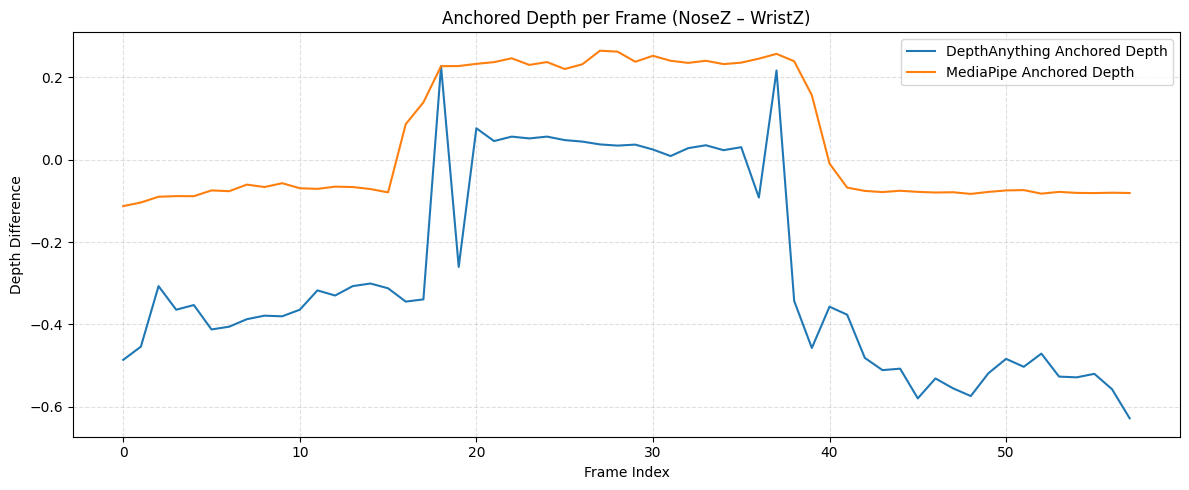

In [3]:

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

plt.plot(anchor_arr_depthanything, label="DepthAnything Anchored Depth")
plt.plot(anchor_arr_mediapipe, label="MediaPipe Anchored Depth")

plt.title("Anchored Depth per Frame (NoseZ – WristZ)")
plt.xlabel("Frame Index")
plt.ylabel("Depth Difference")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()